In [1]:
%load_ext autoreload
%autoreload 2

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.LSTM_fMullerBrown.recursive_LSTM_PostMeanScore_MullerBrown_T256_H05_tl_110data import get_config

In [2]:
config = get_config()

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [4]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

0.0
Using CPU



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.010561345734610582

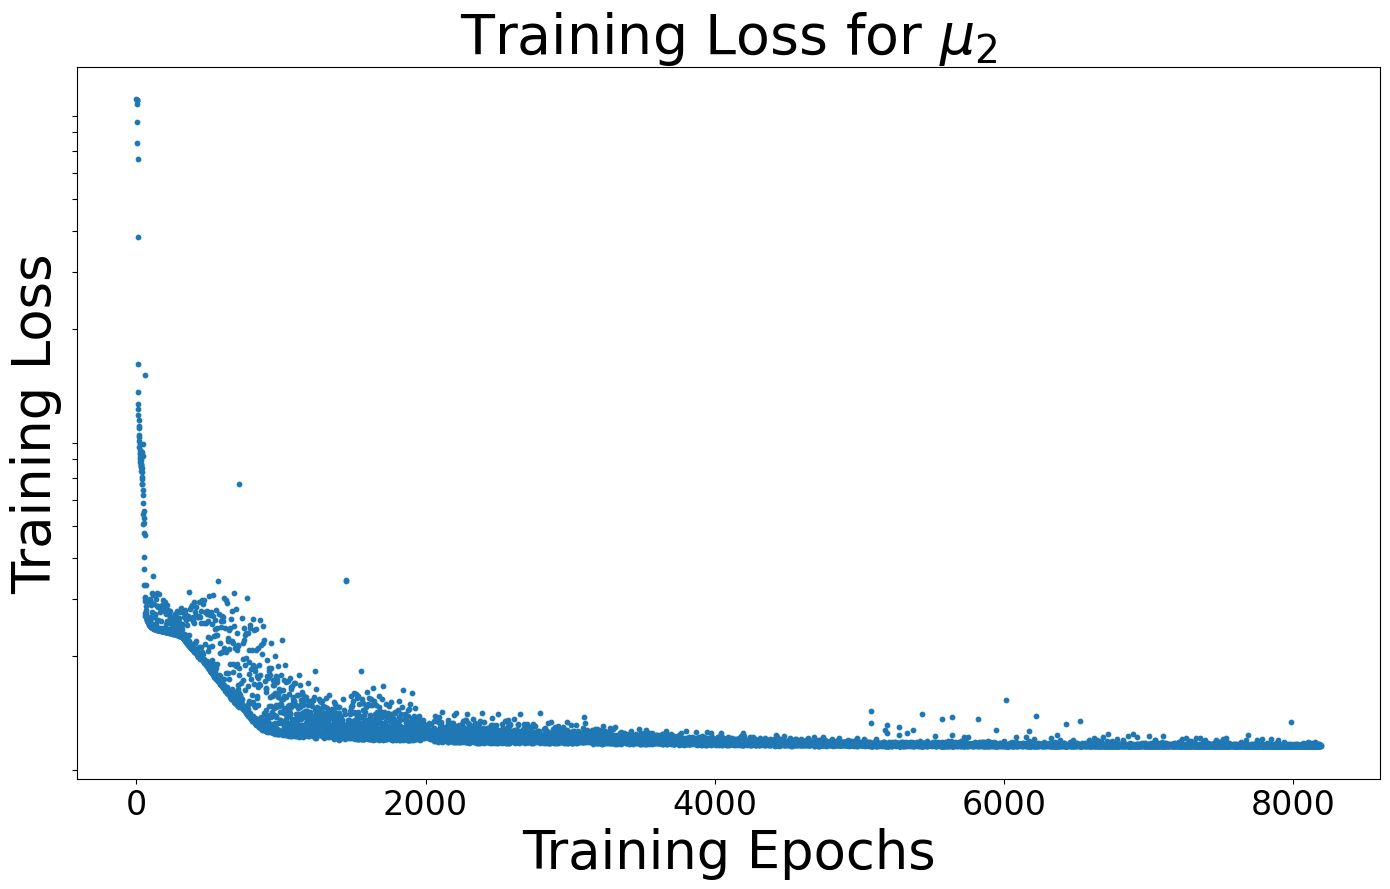

In [5]:
%load_ext autoreload
%autoreload 2
from matplotlib.ticker import LogLocator
gconfig = get_config()
with open(gconfig.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)[:8190]
start_idx = 2
fig, ax = plt.subplots(figsize=(14,9))
ax.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:], s=10)
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_ylabel("Training Loss", fontsize=38)
ax.set_title(r"Training Loss for $\mu_{2}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax.set_yscale("log")
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto', numticks=10))
plt.tight_layout()
losses[-1]/losses[start_idx]

<_io.BufferedReader name='/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_ST_PM_TSM_2LFac_fBiPot_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-05b_00c_LSTM_H20_Nly1_tl110_loss'>


0.36517449694526244

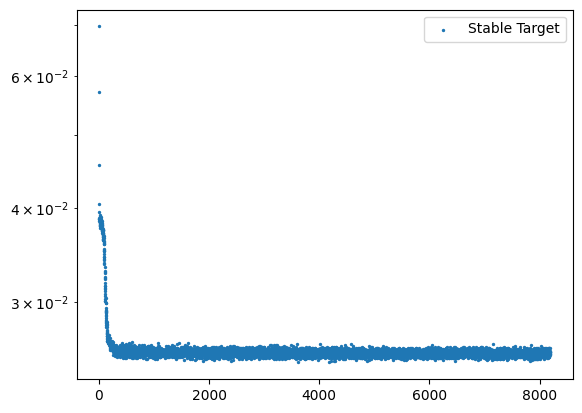

In [6]:
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt import get_config as get_config
gconfig2 = get_config()
with open(gconfig2.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        print(f)
        losses2 = np.array(pickle.load(f))[:losses.shape[0]]
plt.scatter(np.arange(start_idx, losses2.shape[0]), losses2[start_idx:],s=2, label="Stable Target")
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses2[-1]/losses2[start_idx]

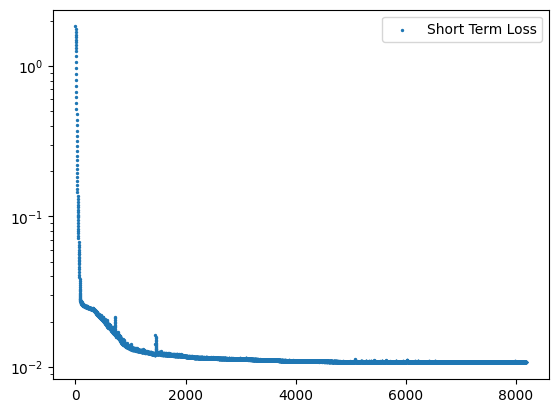

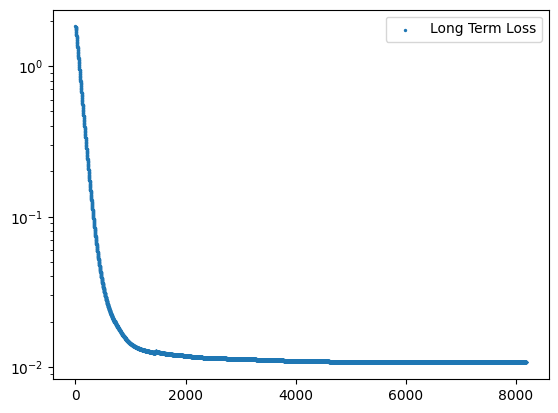

In [7]:
start_idx = 00
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, short_term_ema.shape[0]), (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, long_term_ema.shape[0]), (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [8]:
def find_true_drift(prev, numXs, config):
    assert (prev.shape == (numXs, config.ndims))
    Aks = np.array(config.Aks)[np.newaxis, :]
    aks = np.array(config.aks)[np.newaxis, :]
    bks = np.array(config.bks)[np.newaxis, :]
    cks = np.array(config.cks)[np.newaxis, :]
    X0s = np.array(config.X0s)[np.newaxis, :]
    Y0s = np.array(config.Y0s)[np.newaxis, :]
    common = Aks * np.exp(aks* np.power(prev[:,[0]] - X0s, 2) \
                                 + bks* (prev[:,[0]] - X0s) * (prev[:, [1]] - Y0s)
                                 + cks* np.power(prev[:, [1]] - Y0s, 2))
    assert (common.shape == (numXs, 4))
    drift_X = np.zeros((numXs, config.ndims))
    drift_X[:, 0] = -np.sum(common * (2. * aks* (prev[:, [0]] - X0s) + bks* (prev[:, [1]] - Y0s)), axis=1)
    drift_X[:, 1] = -np.sum(common * (2. * cks* (prev[:, [1]] - Y0s) + bks* (prev[:, [0]] - X0s)), axis=1)

    return drift_X

In [9]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_drift_estimator(mean, true_drift, coords, ts_type, Nepoch, toSave:bool = False):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20,12))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    error_data = np.power(np.mean(np.power(true_drift  - mean,2), axis=-1), 0.5)
    assert (error_data.shape == (true_drift.shape[0],))

    # Extract x and y from coordinates
    x, y = coords[:, 0], coords[:, 1]

    # Create a heatmap using tricontourf
    plt.tricontourf(x, y, error_data, levels=20, cmap="hot")  # Contour plot with 20 levels
    cbar = plt.colorbar(label="RMSE Value")  # Add color bar
    cbar.ax.tick_params(labelsize=38)  # Change font size of numbers on colorbar
    cbar.set_label("RMSE Value", fontsize=38)
    ax.set_title(rf"RMSE {round(rmse,3)} for LSTM Score Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X_{1}$", fontsize=38)
    ax.set_ylabel("State $X_{2}$", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fMullerBrown_DriftEvalExp_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
    plt.show()
    plt.close()

torch.Size([625, 1, 100, 2])
(625, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


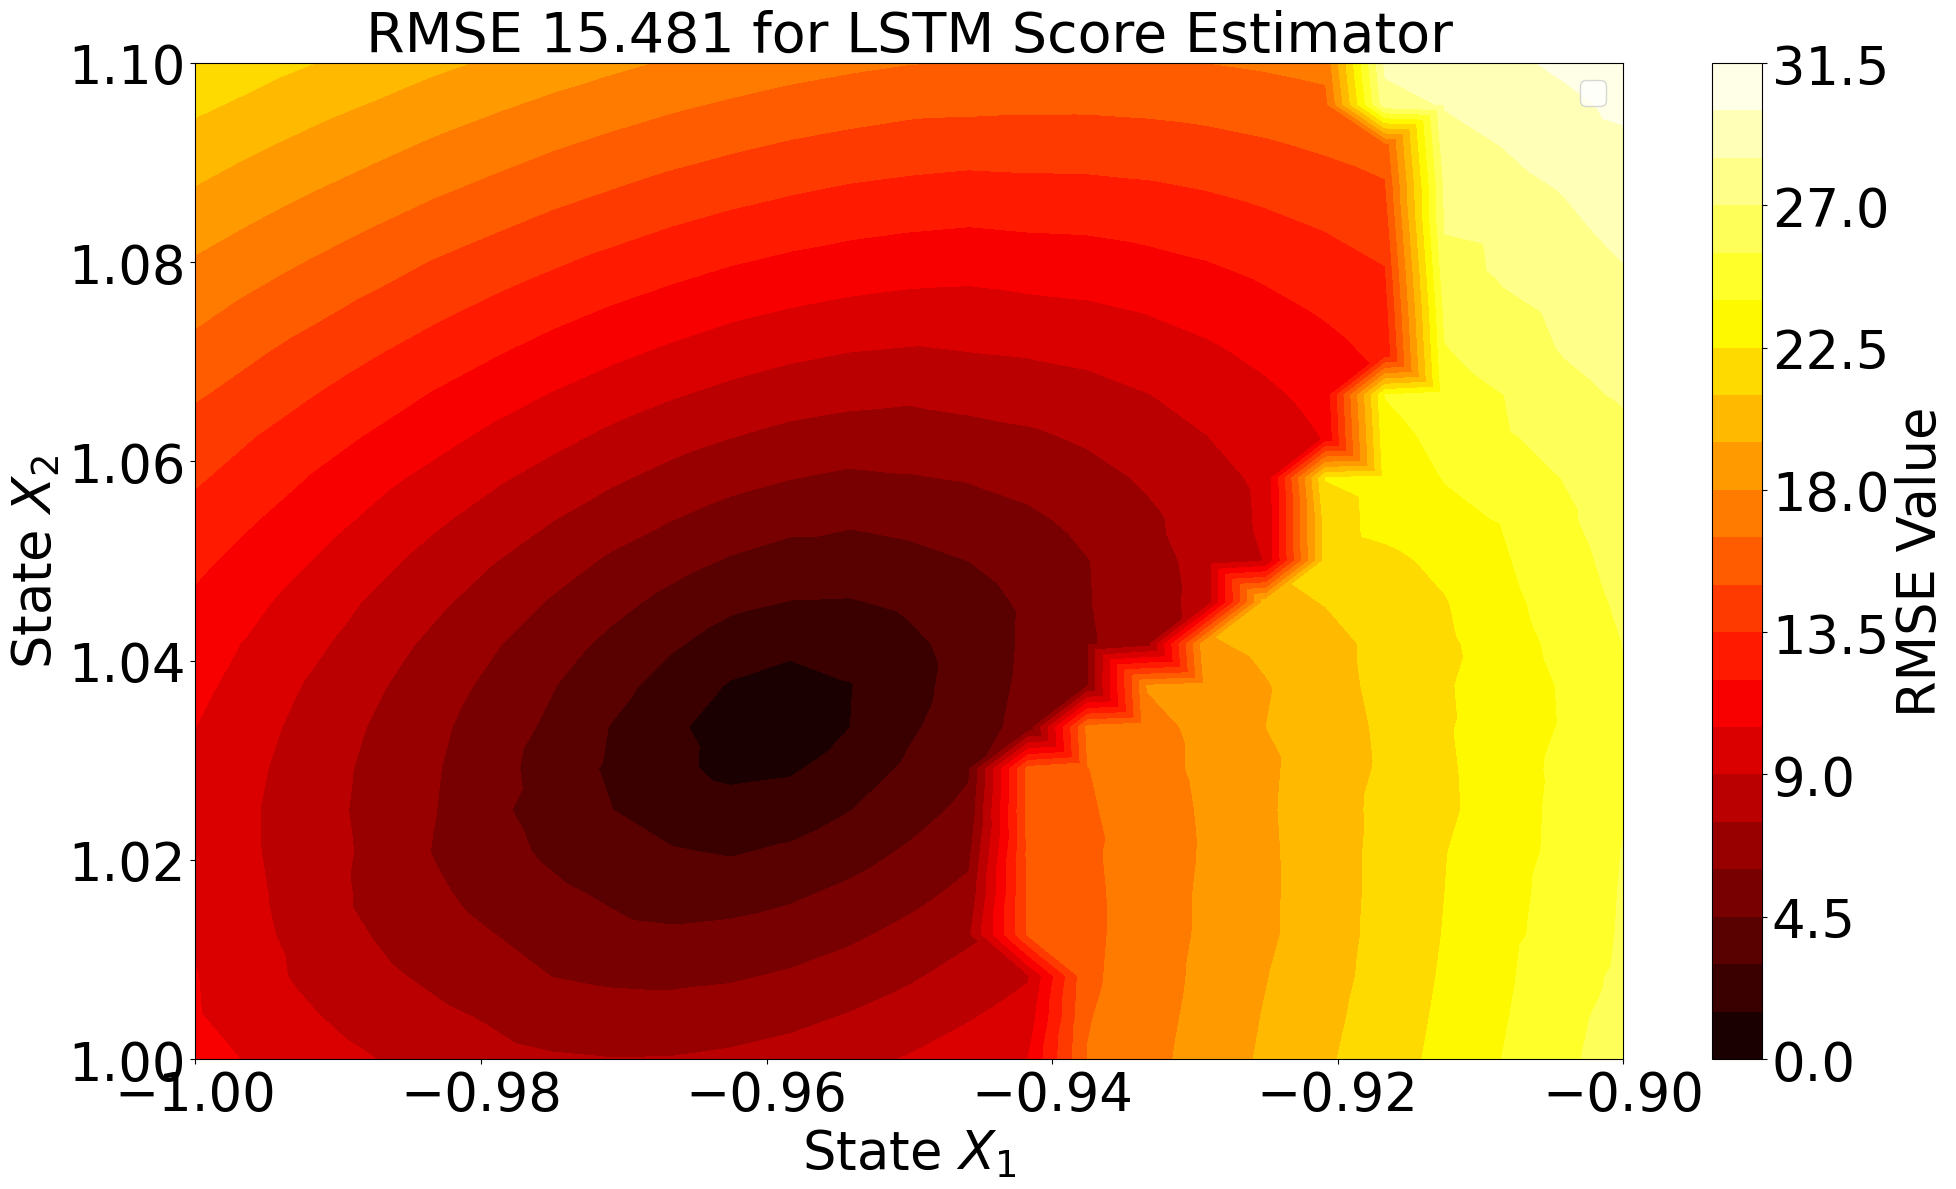

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 60 done with Best RMSE 15.481261253502199




torch.Size([625, 1, 100, 2])
(625, 2)


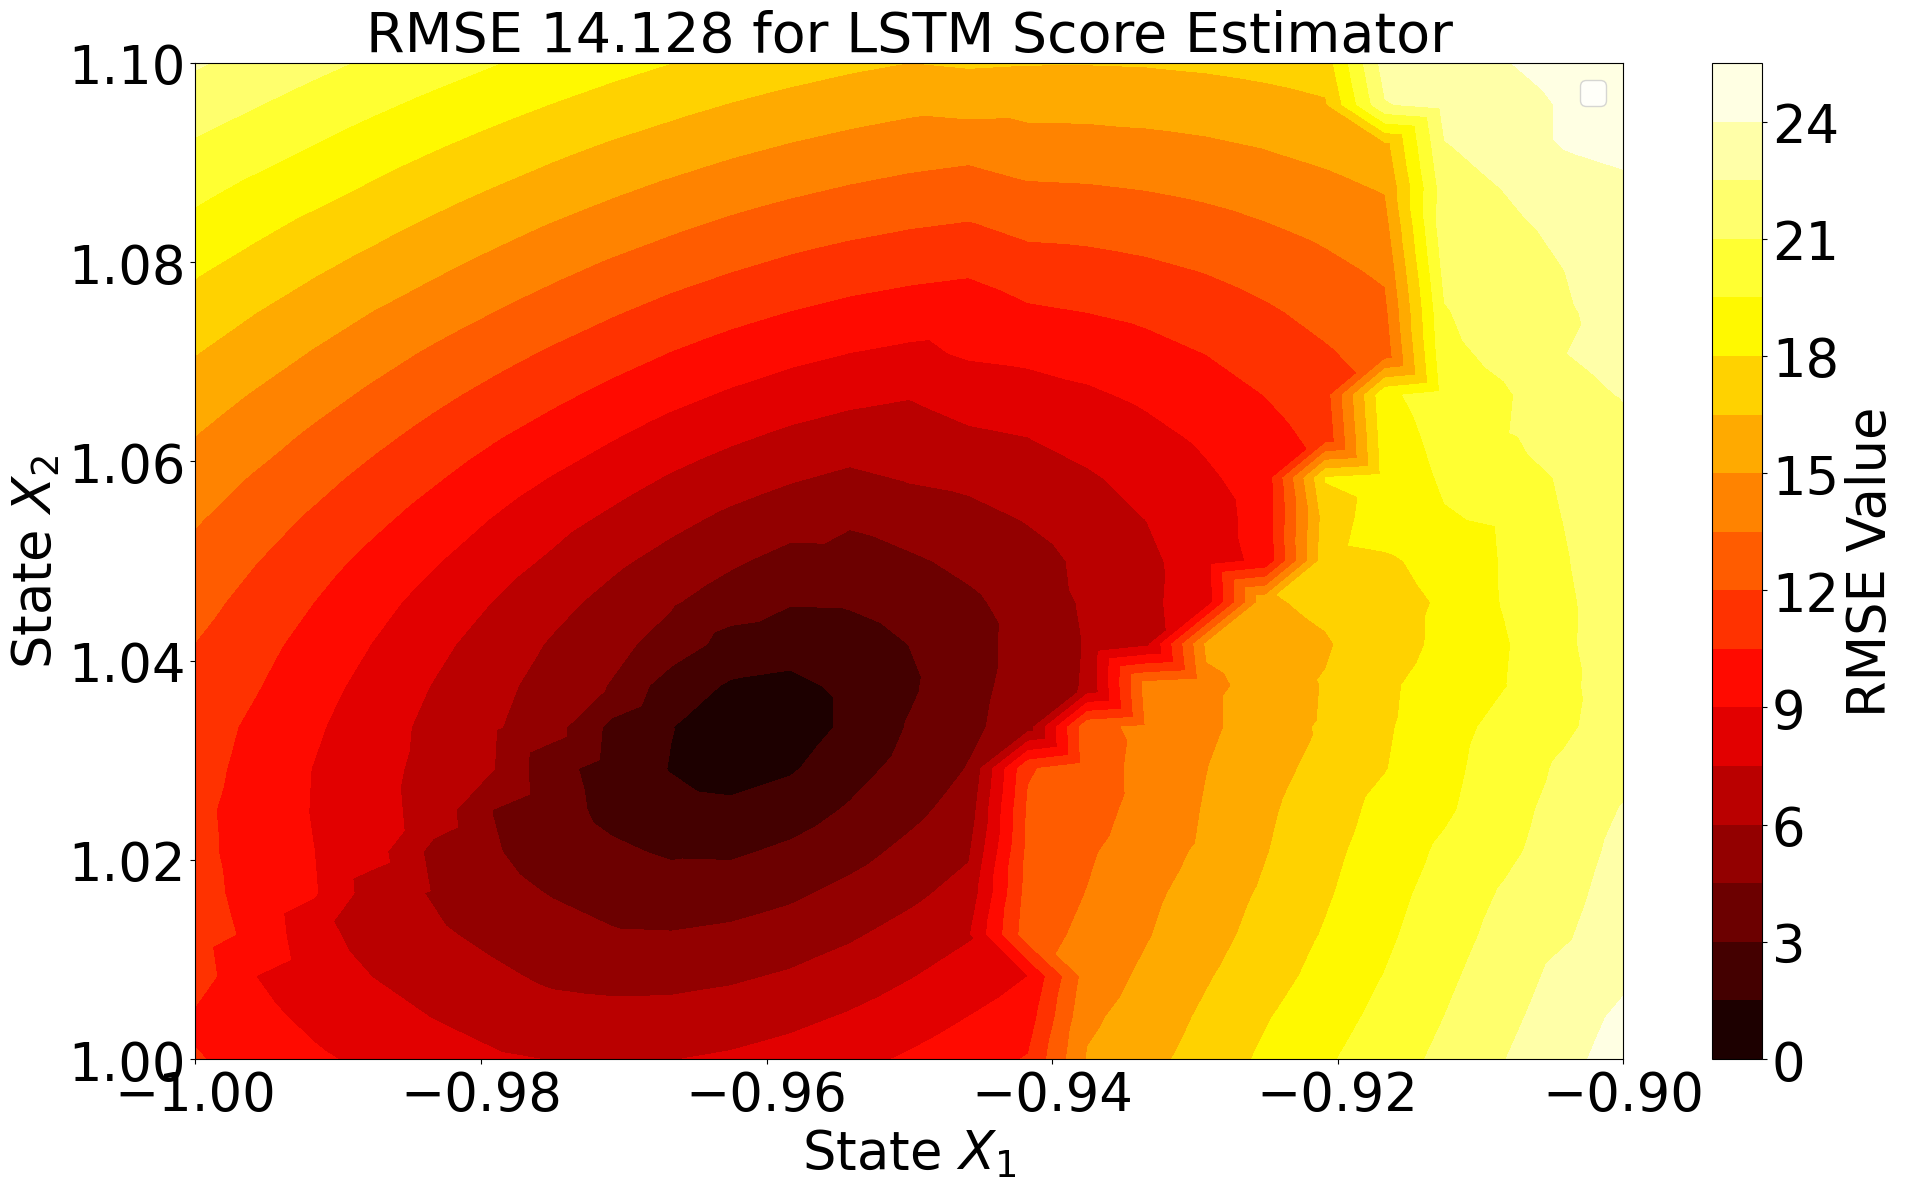

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 100 done with Best RMSE 14.128150867391874




torch.Size([625, 1, 100, 2])
(625, 2)


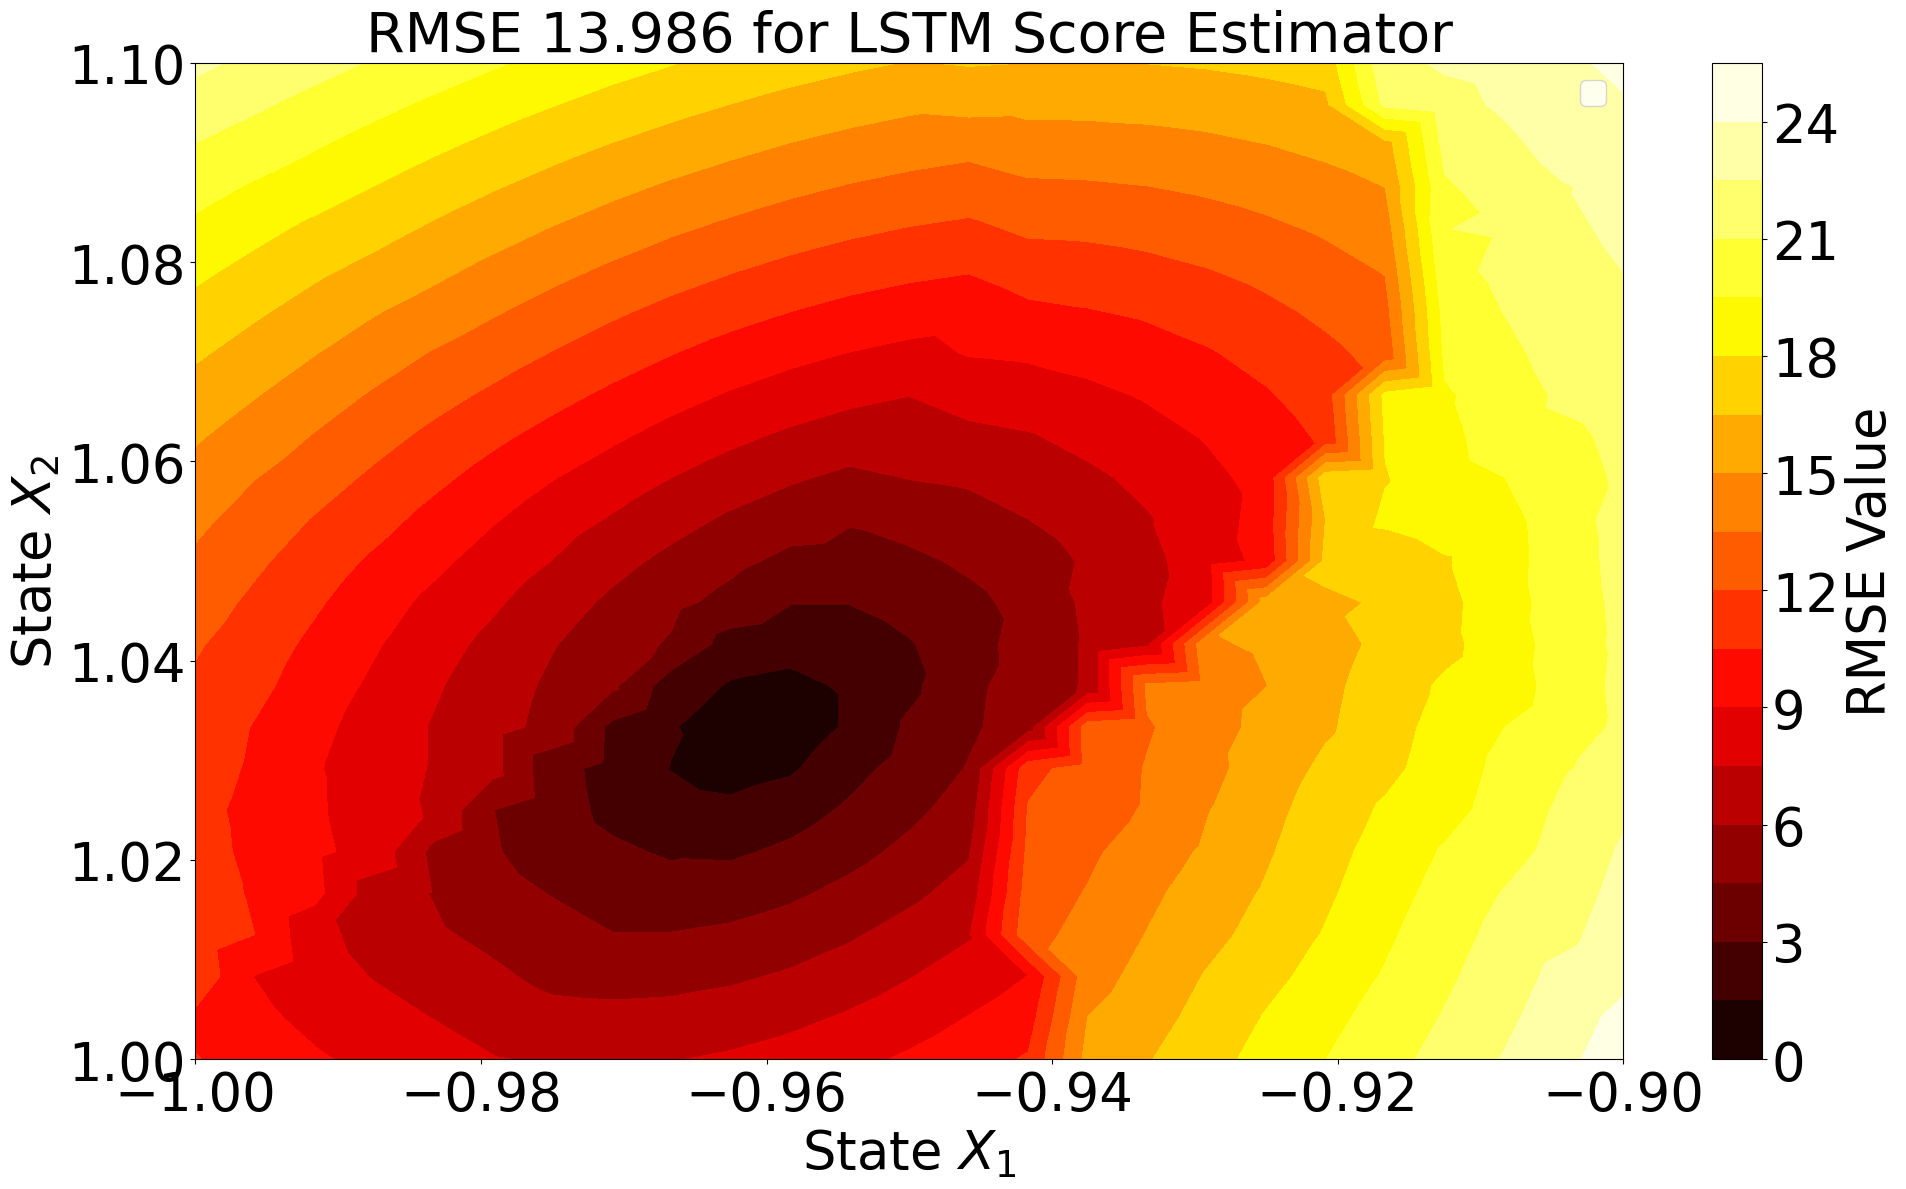

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 150 done with Best RMSE 13.986156030256724




torch.Size([625, 1, 100, 2])
(625, 2)


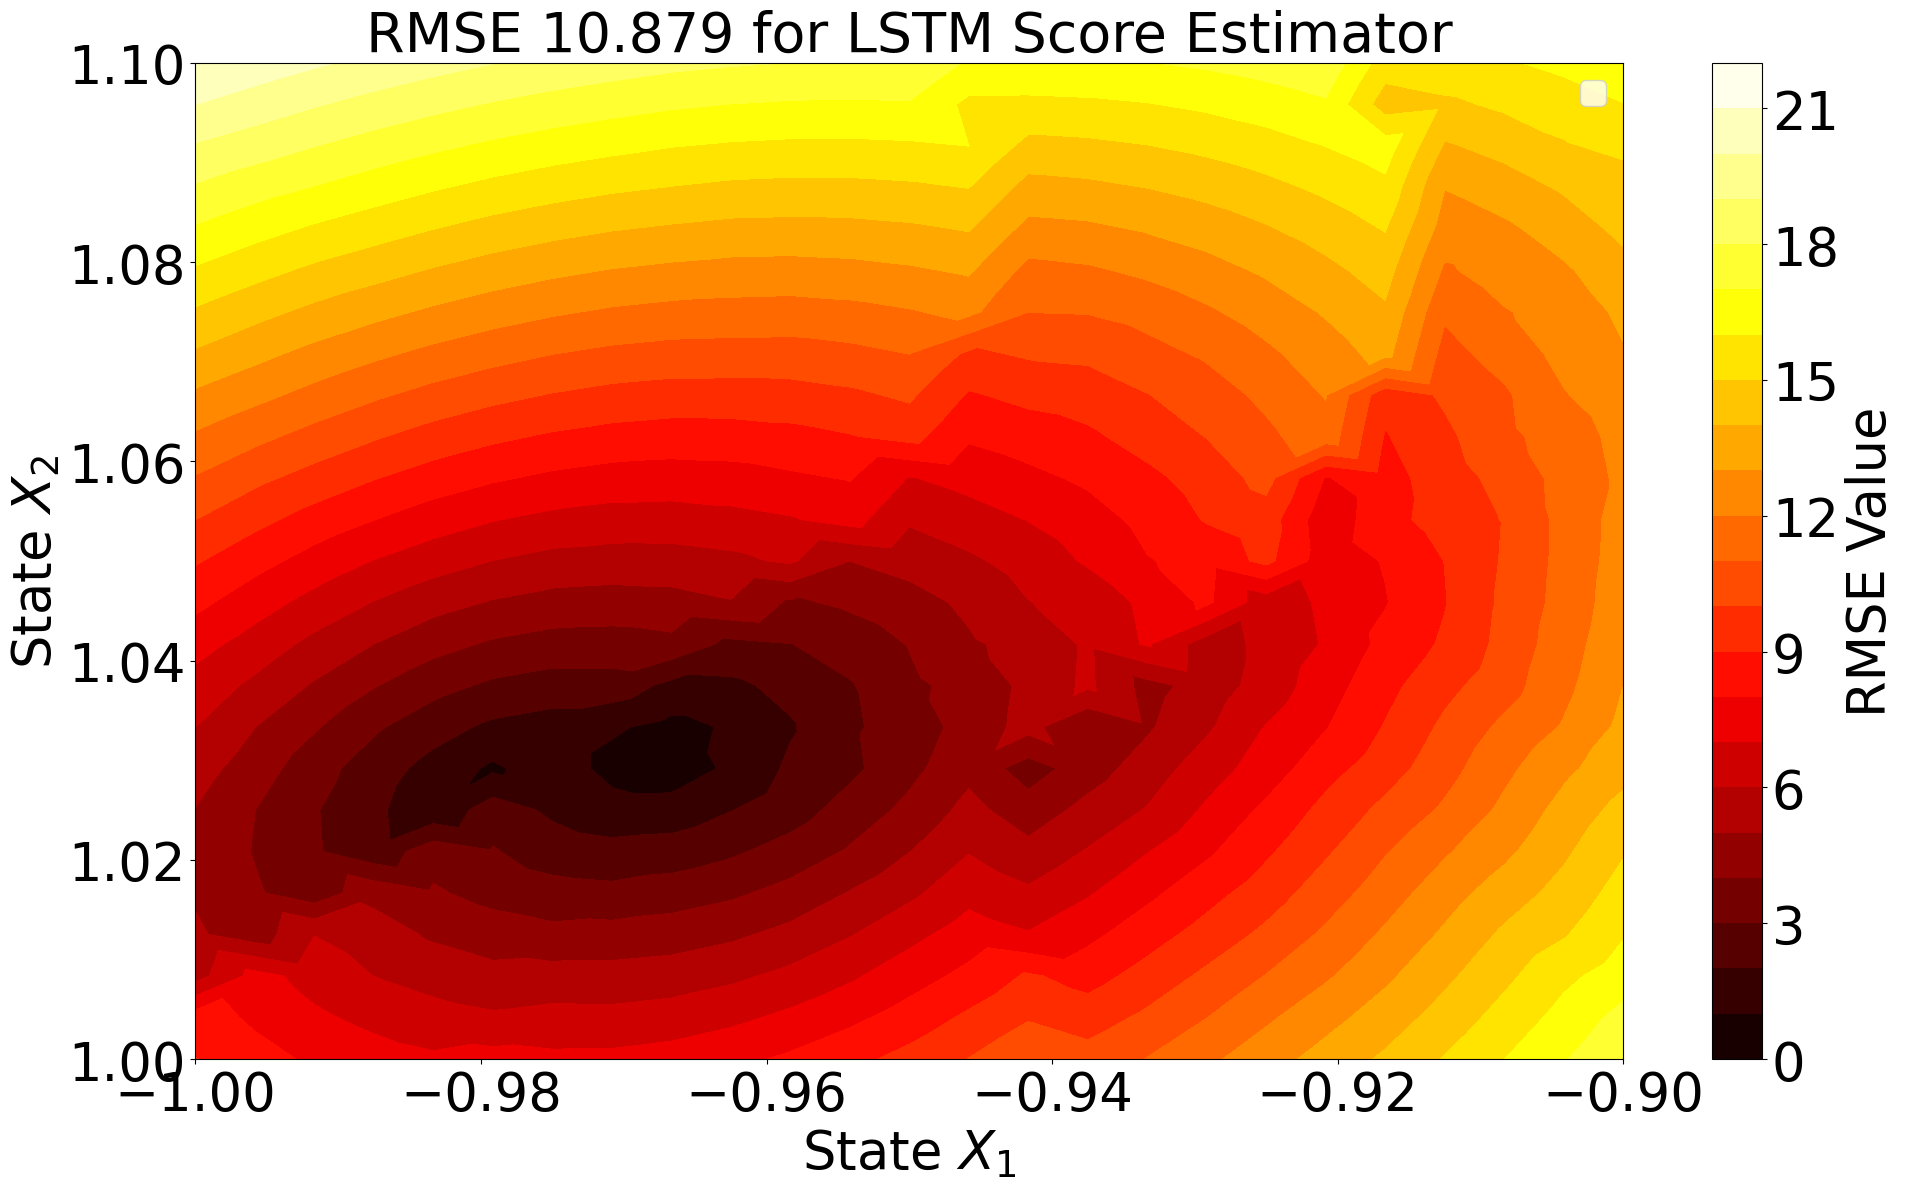

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 300 done with Best RMSE 10.878756861276553




torch.Size([625, 1, 100, 2])
(625, 2)


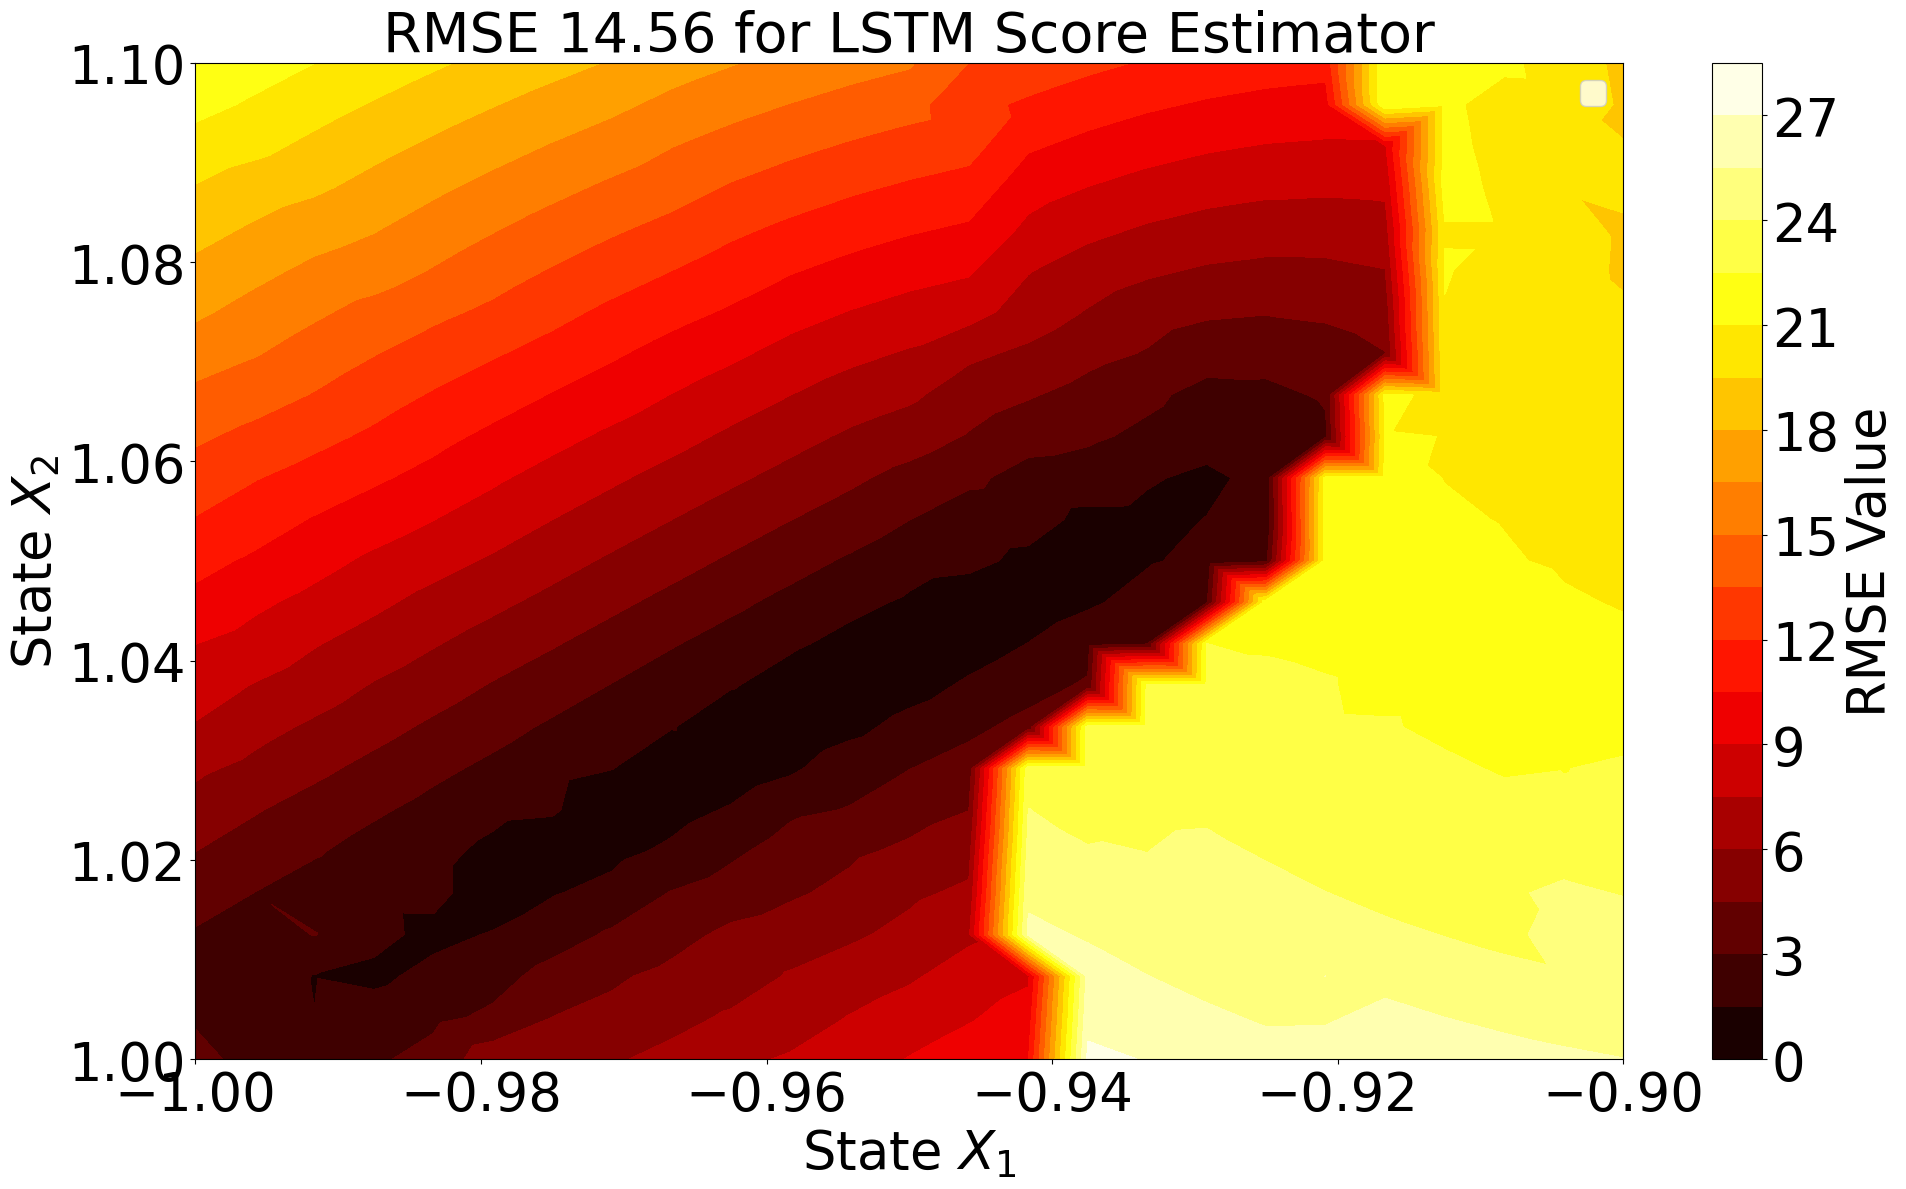

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 960 done with Best RMSE 14.56022978356177




torch.Size([625, 1, 100, 2])
(625, 2)


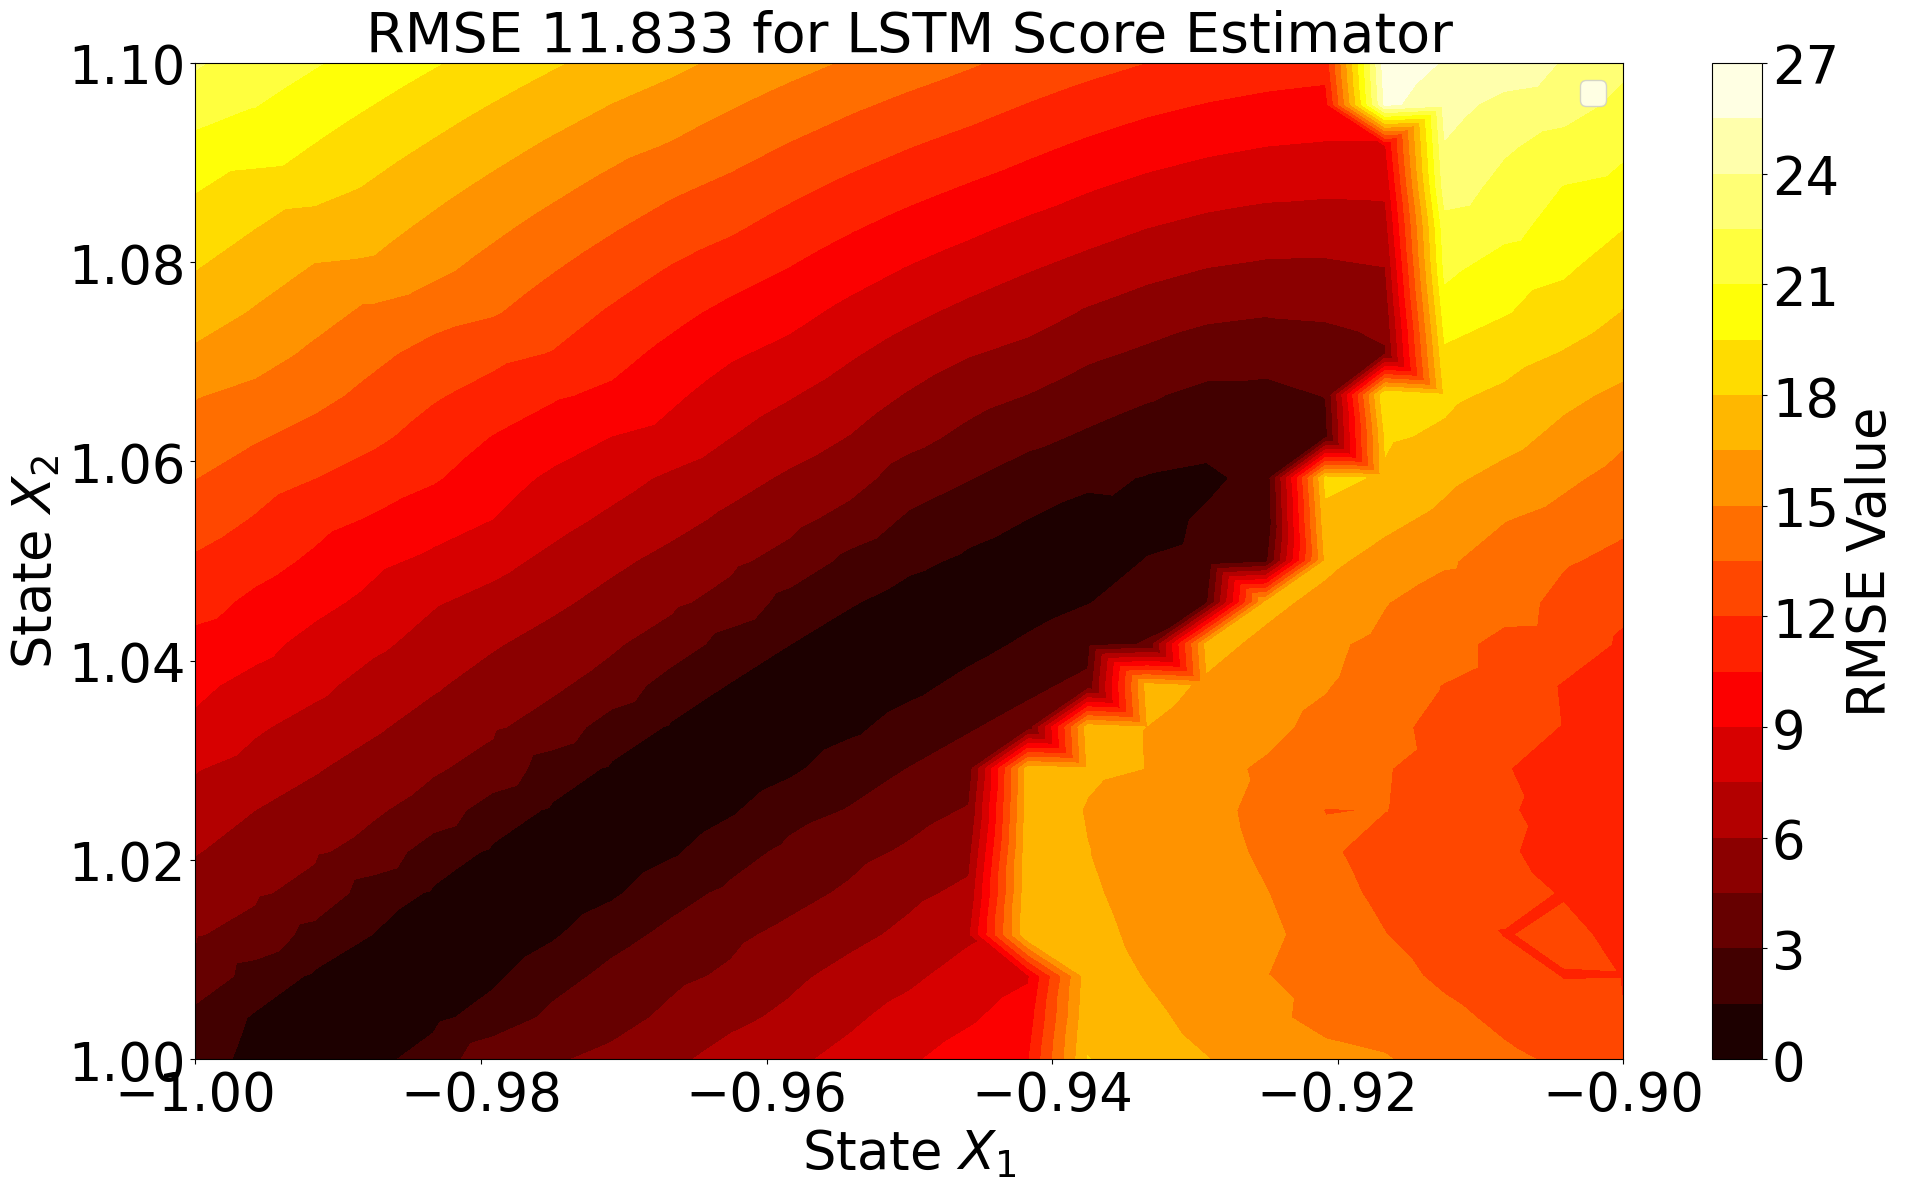

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 1440 done with Best RMSE 11.83289358307615




torch.Size([625, 1, 100, 2])
(625, 2)


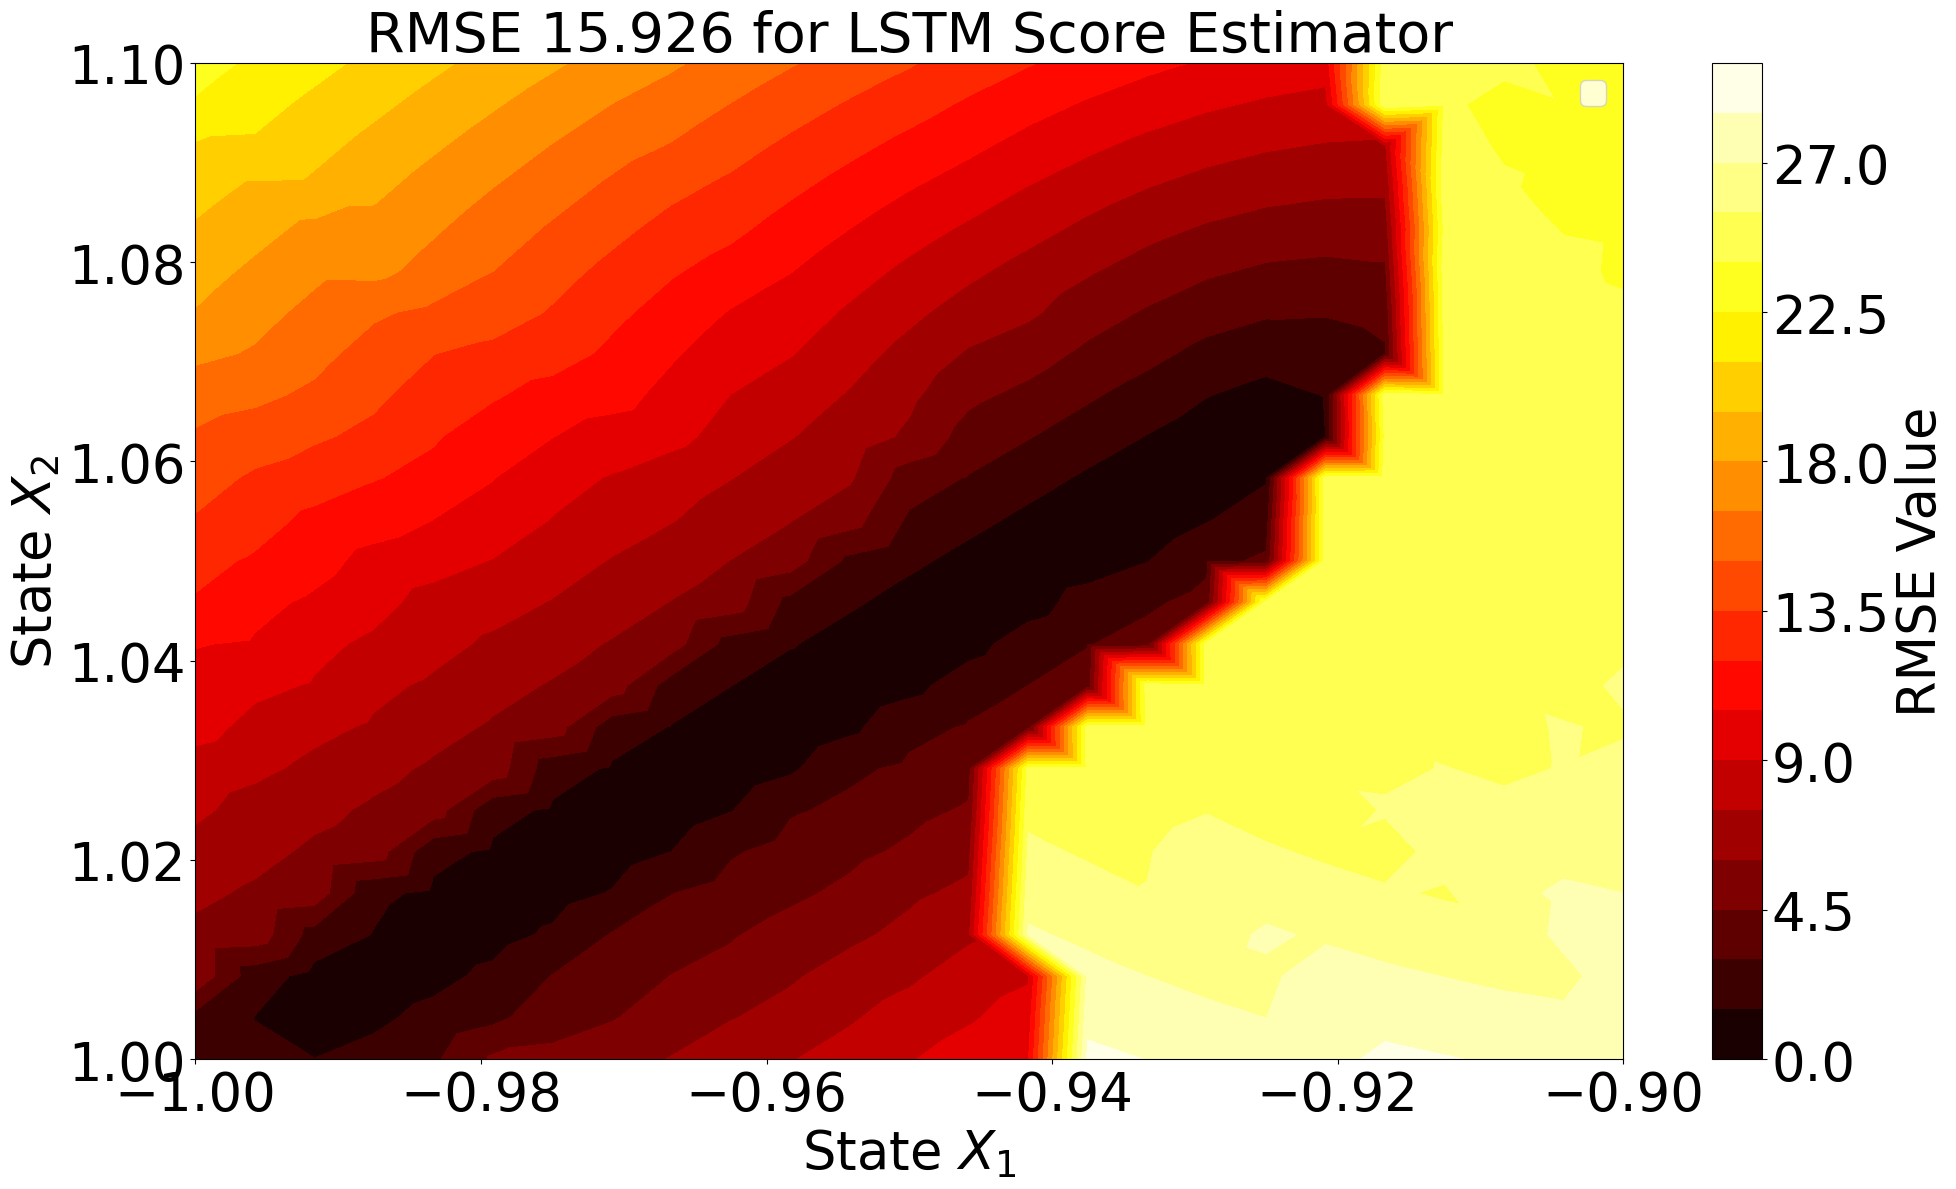

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 1920 done with Best RMSE 15.926330919724231




torch.Size([625, 1, 100, 2])
(625, 2)


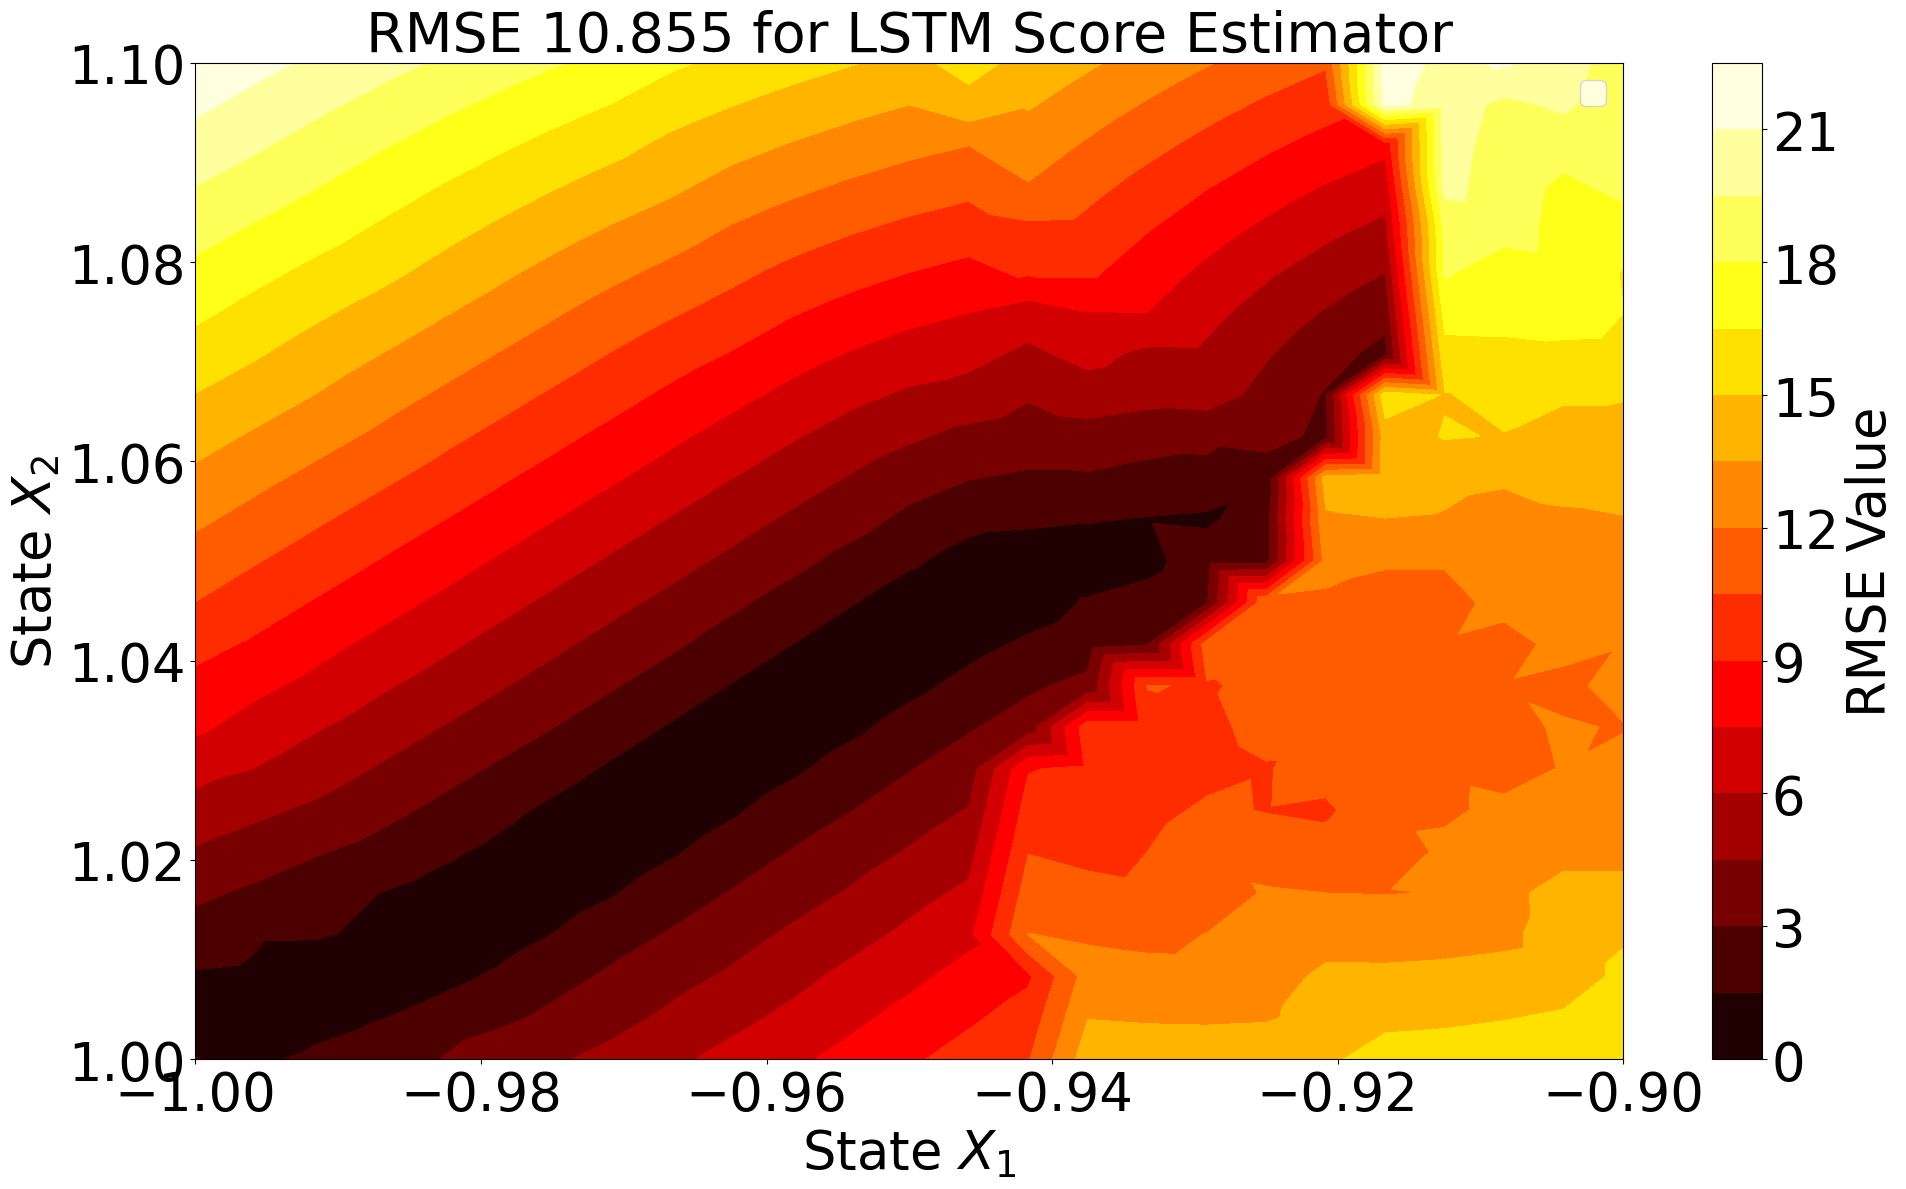

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 2920 done with Best RMSE 10.854879662539902




torch.Size([625, 1, 100, 2])
(625, 2)


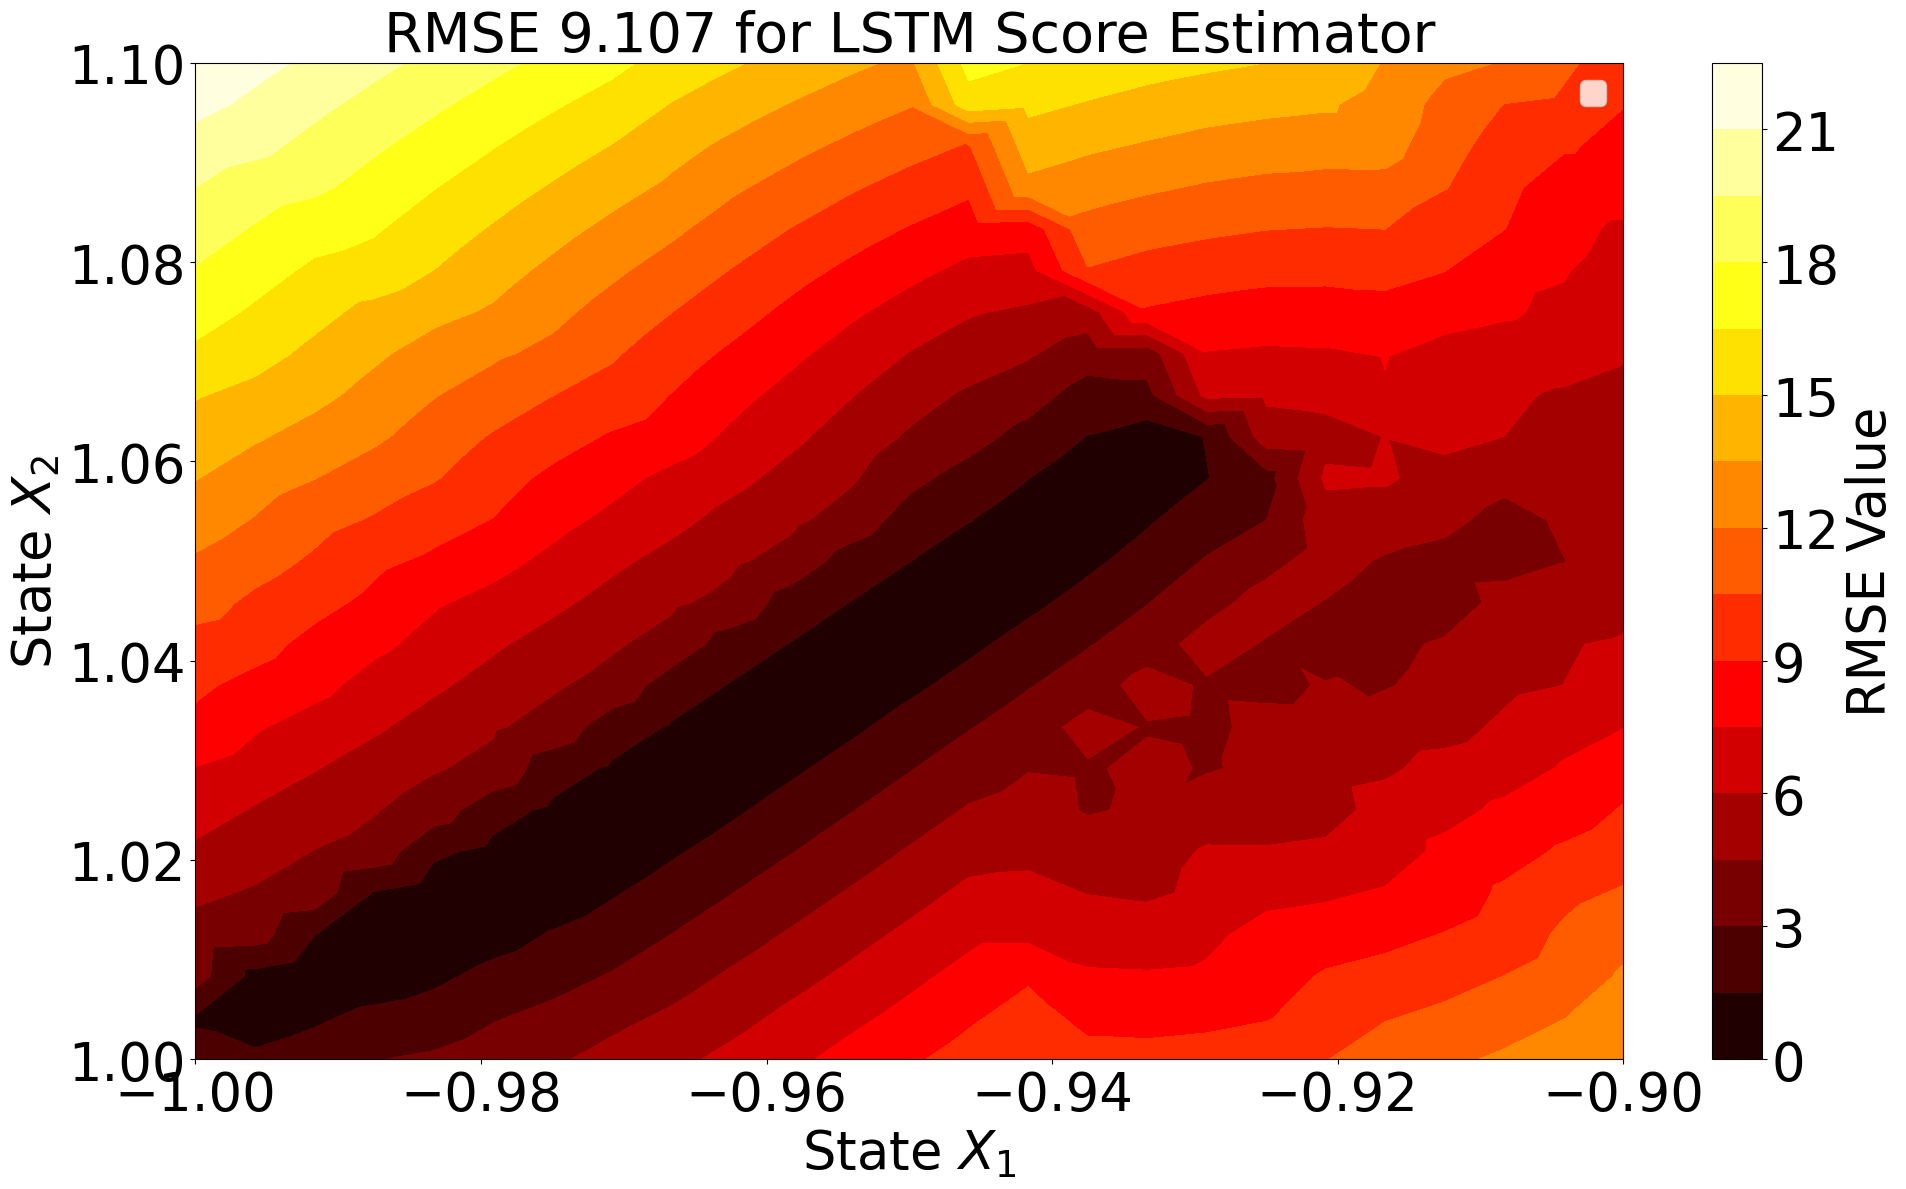

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 6920 done with Best RMSE 9.107261000534269




torch.Size([625, 1, 100, 2])
(625, 2)


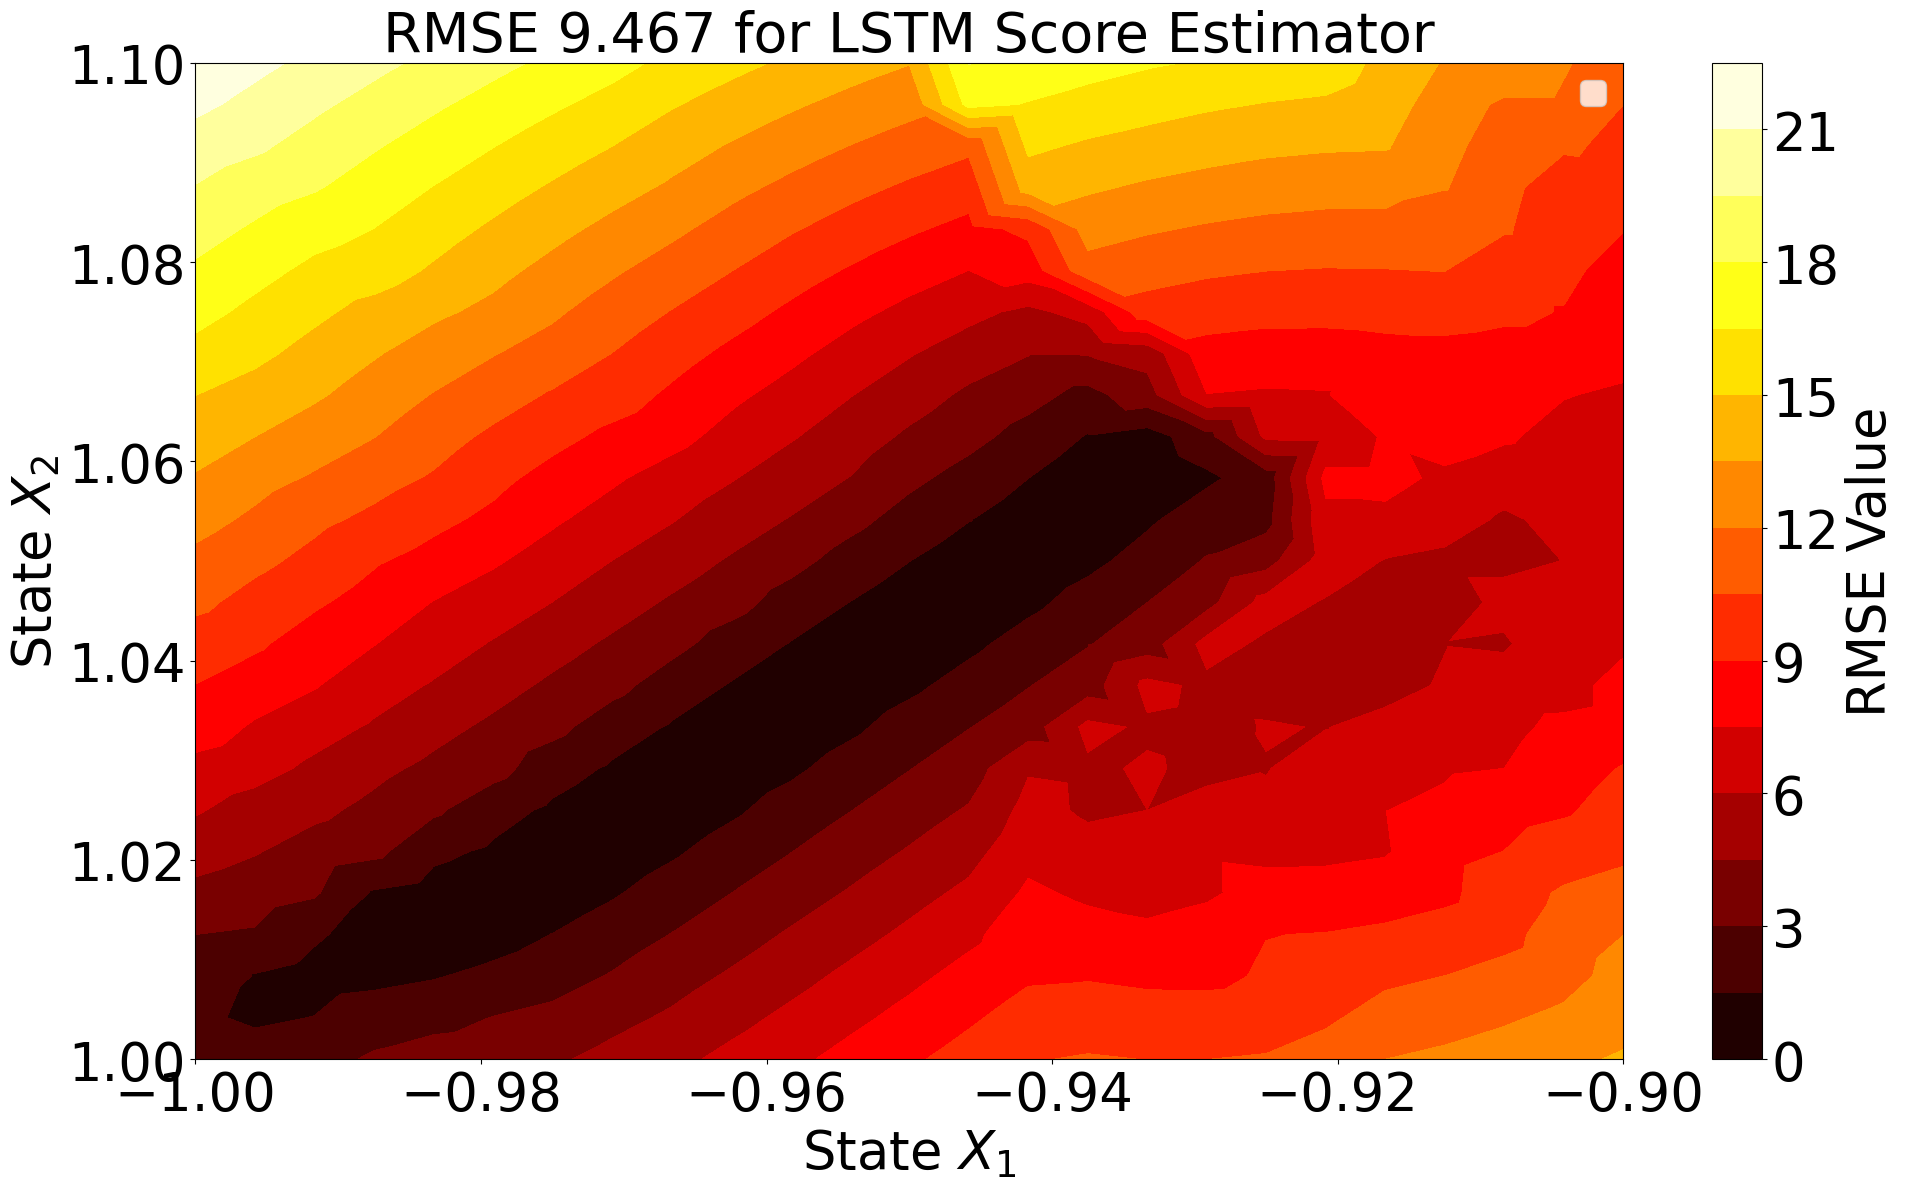

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 7190 done with Best RMSE 9.467163681572826




torch.Size([625, 1, 100, 2])
(625, 2)


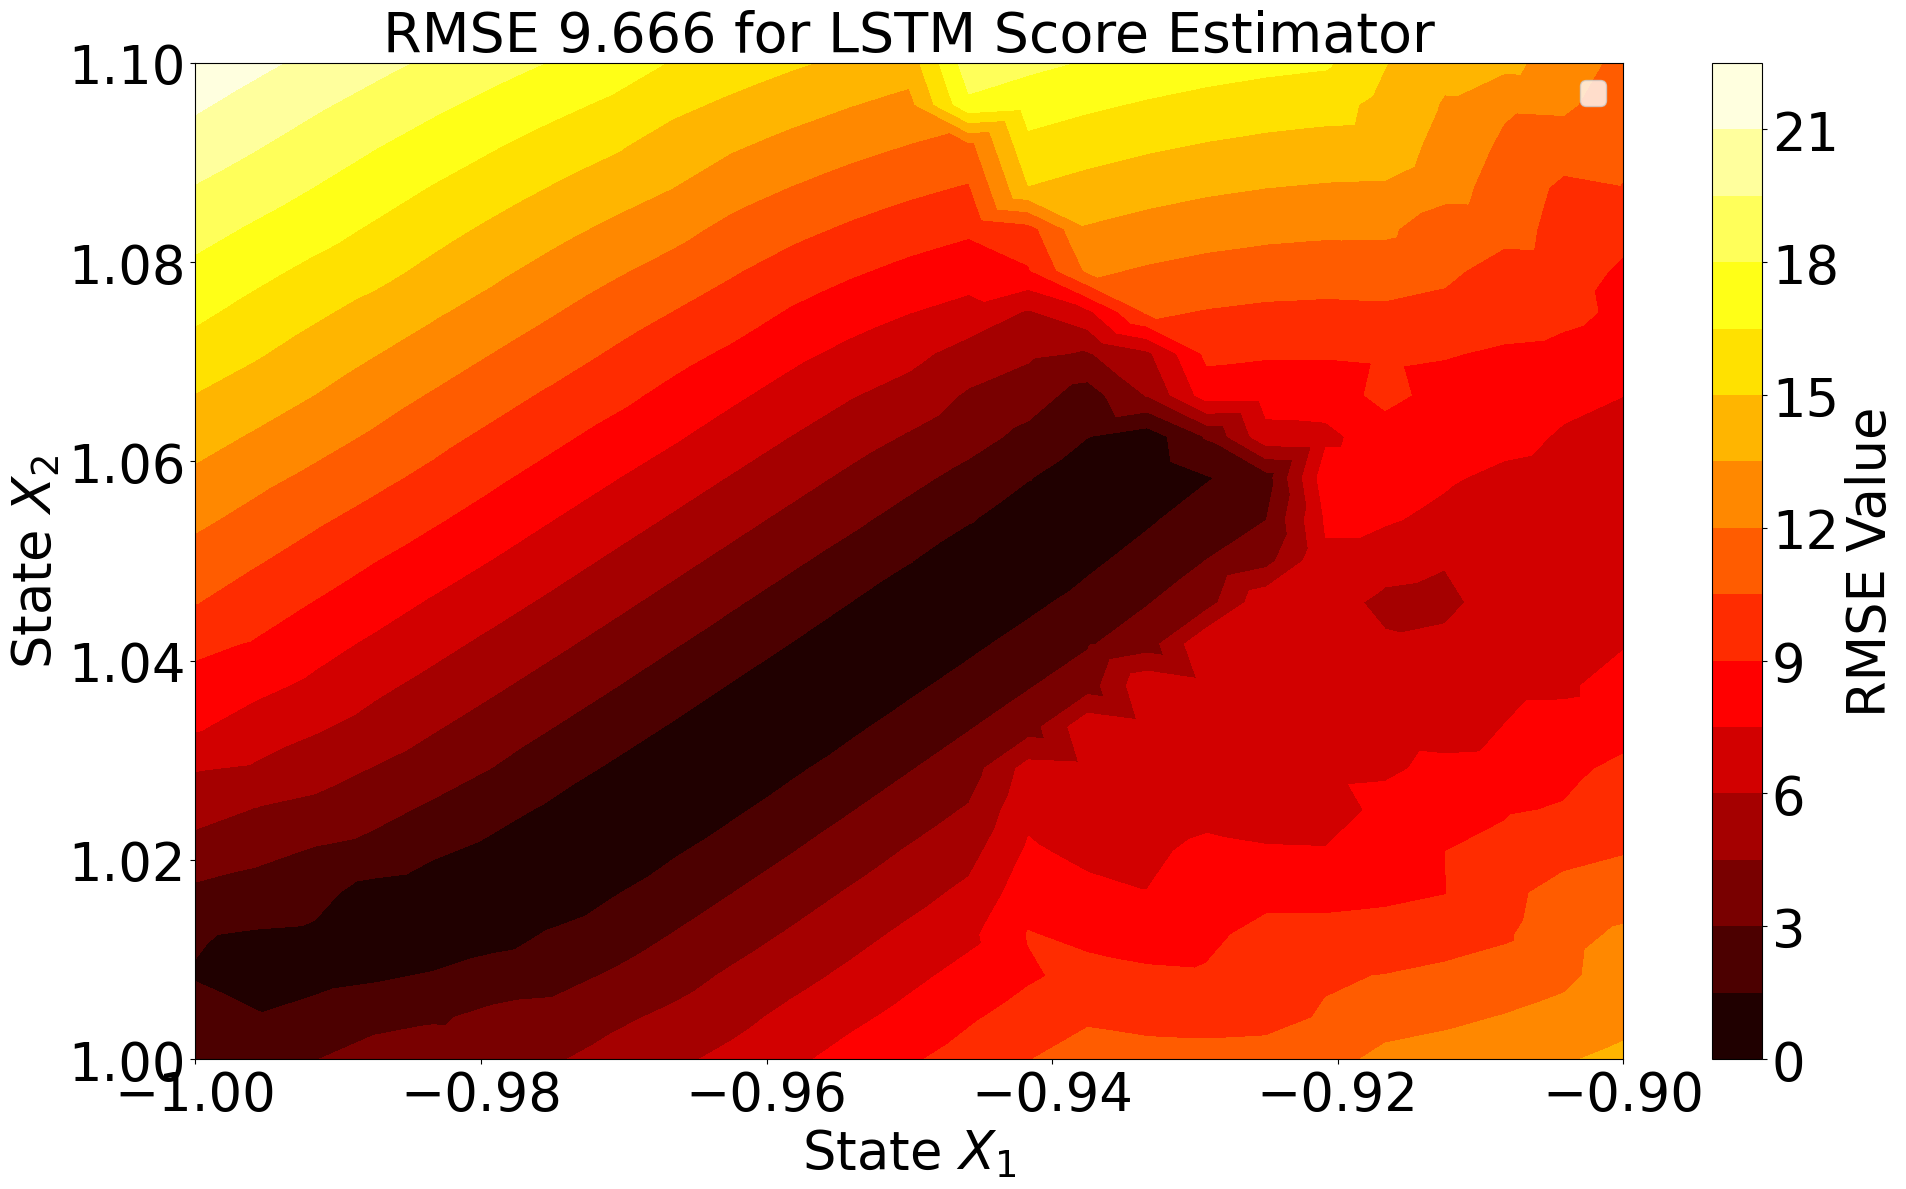

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 8190 done with Best RMSE 9.666107849785163




torch.Size([625, 1, 100, 2])
(625, 2)


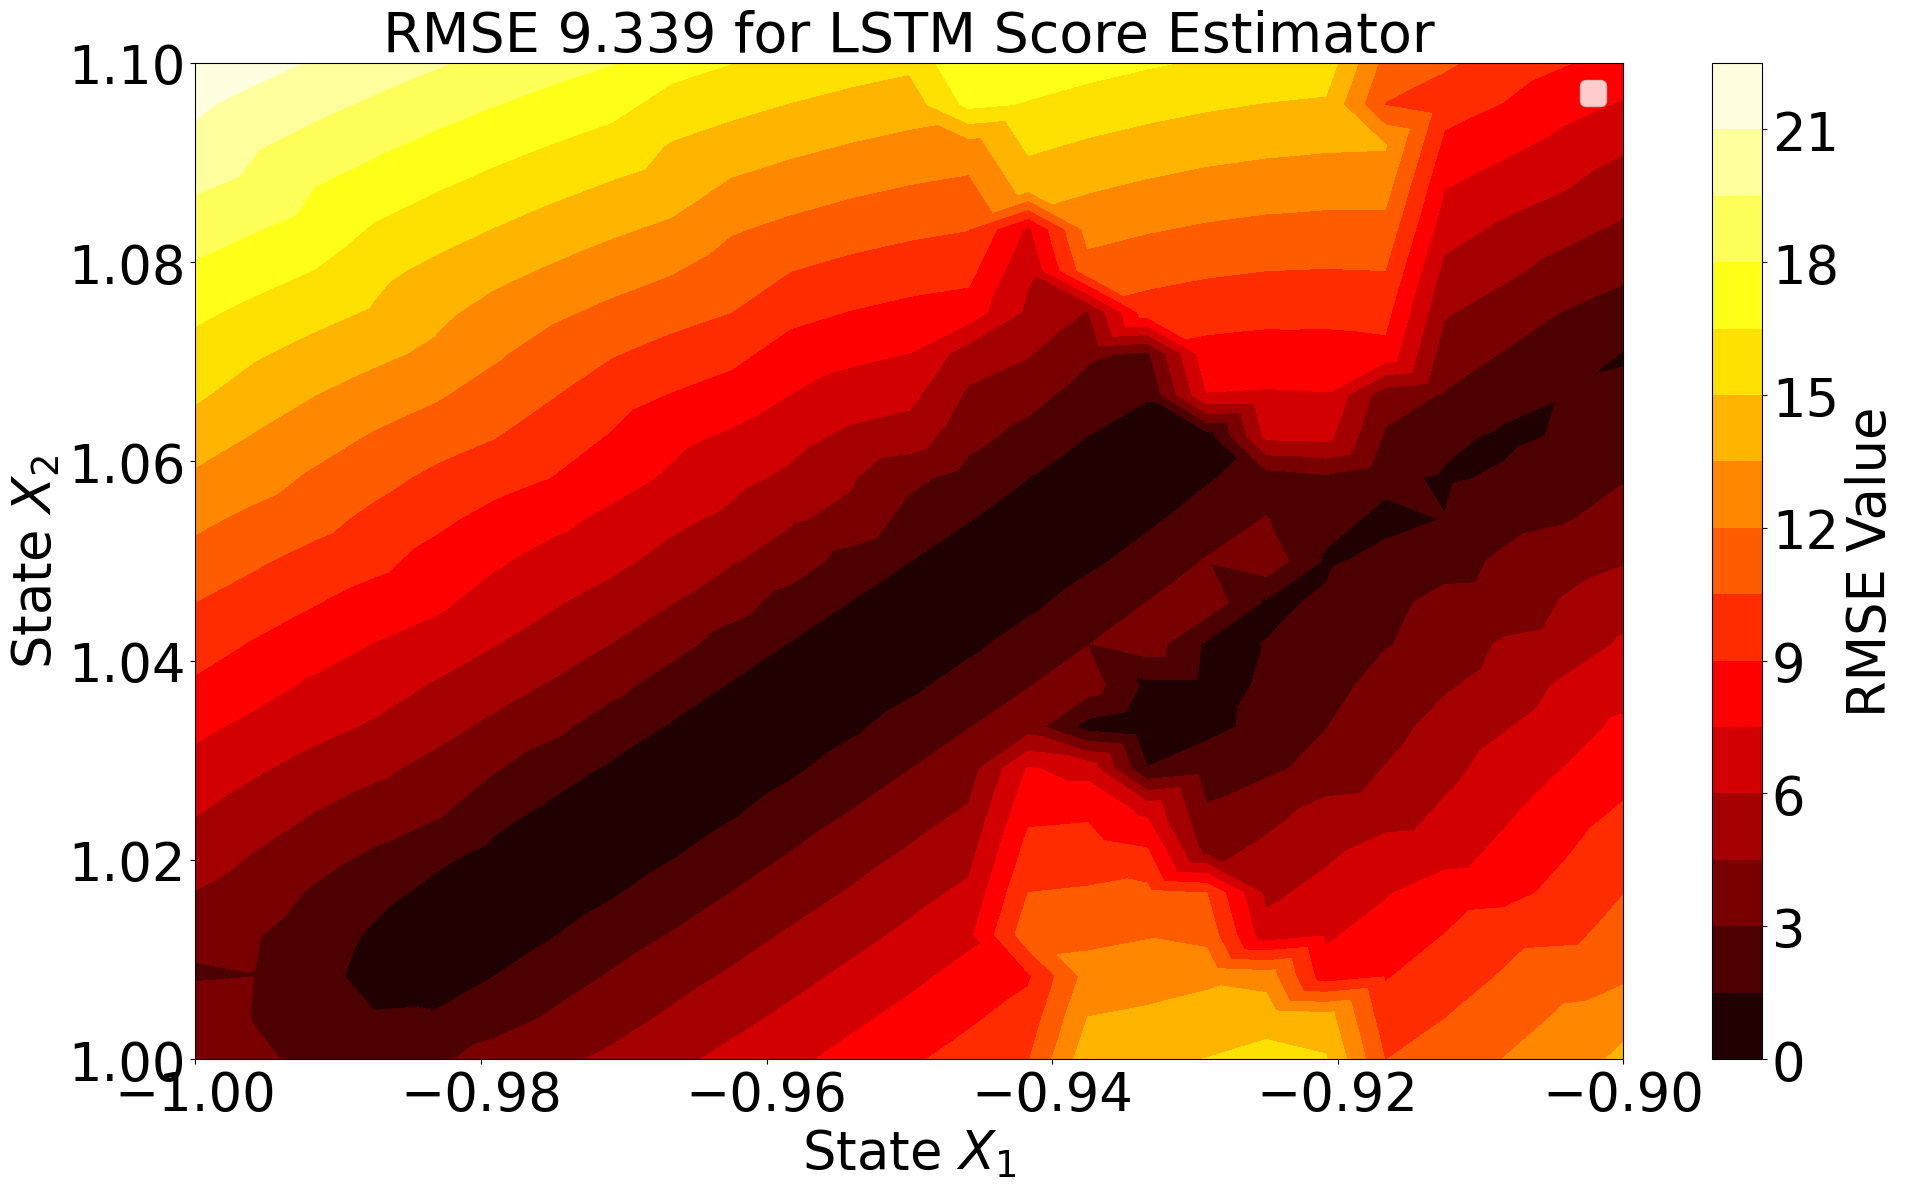

Epoch 12920 done with Best RMSE 9.338812427020562






In [11]:
best_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        Ndiff = config.max_diff_steps
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""
        if "_ST_" in config.scoreNet_trained_path:
            file_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fMullerBrown_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        else:
            file_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fMullerBrown_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        muhats = torch.Tensor(np.load(file_path+"_muhats.npy"))
        print(muhats.shape)
        Xshape = muhats.shape[0]
        numXs = 25
        minx = -1.
        maxx = -0.9
        Xs = np.linspace(minx, maxx, numXs)
        miny = 1.
        maxy = 1.1
        Ys = np.linspace(miny, maxy, numXs)
        X, Y = np.meshgrid(Xs, Ys)
        Xs = np.column_stack([X.ravel(), Y.ravel()])
        ts_type = "MullerBrown"
        assert (config.max_diff_steps == 10000)
        true_drifts = find_true_drift(prev=Xs, numXs=Xshape, config=config)
        mu_hats = muhats[:, -1, :, :].reshape(muhats.shape[0], muhats.shape[2]*1, muhats.shape[-1]).mean(dim=1).numpy()
        print(mu_hats.shape)
        stds = muhats[:, -1, :, :].reshape(muhats.shape[0], muhats.shape[2]*1, muhats.shape[-1]).std(dim=1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        if rmse < np.inf*best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, toSave=toSave, true_drift=true_drifts, ts_type=ts_type, Nepoch=Nepoch,  coords=Xs)
            print(f"Epoch {Nepoch} done with Best RMSE {best_rmse}\n\n\n\n")
        del muhats, mu_hats, stds, true_drifts
    except FileNotFoundError as e:
        print(e)
        continue